In [30]:
import sklearn
import tensorflow as tf
import os,cv2
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from PIL import Image
import os, os.path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers, optimizers,initializers
from tensorflow.keras.layers import BatchNormalization,MaxPool2D
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Dropout,Flatten,Input,Conv2DTranspose,concatenate,GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix
from keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from keras.preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img
import shutil

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [4]:
from zipfile import ZipFile

with ZipFile('train.zip','a') as z:
    z.extractall()

In [5]:
train_data = pd.read_csv('train.csv')
train_data.head()

,file_id,label
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [6]:
train_data.shape

(1709, 2)

In [7]:
def getFileName(filename):
    field_id = filename.rsplit('\\',1)[1]
    field_id = field_id.rsplit('.',1)[0]
    return field_id
    

In [8]:
def target_label(filename):
    field_id = filename.rsplit('\\',1)[1]
    field_id = field_id.rsplit('.',1)[0]
    x =  int(train_data[train_data['file_id'] == int(field_id)]['label'])
    return x
    
    #return int(train_data[train_data['file_id'] == int(field_id)]['label'])
   

C:\Users\Venkat K Pillai\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(1, 950, '949')

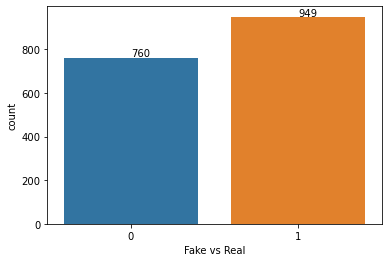

In [9]:
sns.countplot(train_data['label'])
plt.xlabel('Fake vs Real')
plt.text(x=0,y=770,s=train_data.value_counts('label')[0])
plt.text(x=1,y=950,s=train_data.value_counts('label')[1])

 Merge fake and real images folder

In [10]:
def addAgumentedData(label,img):
    label_list = []
    file_list  = []
    datagen = ImageDataGenerator(rotation_range = 40,shear_range = 0.2,zoom_range = 0.2,horizontal_flip = True,brightness_range = (0.5, 1.5))
    img = img
    x = img_to_array(img)
    x = x.reshape((1, ) + x.shape) 
    i = 0
    for batch in datagen.flow(x, batch_size = 1,save_to_dir ='preview',save_prefix ='image', save_format ='jpg'):
        i += 1   
        if i > 3:
            break
    allfiles = os.listdir('preview')
 
    for f in allfiles:
        file_list.append(f)
        label_list.append(label)
        shutil.move('./preview/' + f, './train/' + f)
    return file_list,label_list

In [11]:
#Load images to system

In [16]:
def load_data(mode):
    count = 0
    if(mode == "Train"):
        images_folder = "train"
        filenames = [os.path.join(images_folder,file) for file in os.listdir(images_folder) if file.endswith(".jpg")]
        images = []
        labels = []
        global agumented_images
        agumented_images = []
        global agumented_labels
        agumented_labels = []
        for f in filenames:
            img = Image.open(f)
            label = target_label(f)
            #f1,l1 = addAgumentedData(label,img)
            #agumented_images.extend(f1)
            #agumented_labels.extend(l1)
                #train_data = train_data.append({'file_id':f1, 'label':l1}, ignore_index=True)
            # Resize images to 256x256.
            img = img.resize((256, 256), Image.ANTIALIAS)
            img = np.array(img, dtype=np.float32)
            # Normalize the images.
            img = img / 255.
            images.append(img)
            #label = arget_label(f)
            #addAgumentedData(f,label)
            #label = np.expand_dims(label, axis=0)
            #label = label / 255.
            labels.append(label)
        images = np.array(images)
        labels = np.array(labels)
        return images, labels
    
    if mode == "Test":
        images_folder = "test"
        labels_folder = "test_label"
        if not os.path.isdir("test_label"):
            os.makedirs("test_label")
        filenames = [os.path.join(images_folder,file) for file in os.listdir(images_folder) if file.endswith(".jpg")]
        images = []
        label_name = []
        height = []
        width = []
        for f in filenames:
            img = Image.open(f)
            width.append(img.size[0])
            height.append(img.size[1])
            img = img.resize((128, 128), Image.ANTIALIAS)
            img = np.array(img, dtype=np.float32)
            img = img / 255.
            images.append(img)
            #id = re.search("Unet_usecase/test_raw/(.+).jpg", f).group(1)
            #label_file = labels_folder+"/"+id+".jpg"
            label_name.append(getFileName(f))
        images = np.array(images)
        label_name = np.array(label_name)
        height = np.array(height)
        width = np.array(width)
        return images, label_name, height, width

In [17]:
def unet_model():
    
    model = Sequential()
    model.add(Conv2D(input_shape=(128,128,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),name='vgg16'))
    model.add(Flatten(name='flatten'))
    model.add(Dense(256, activation='relu', name='fc1'))
    model.add(Dense(128, activation='relu', name='fc2'))
    model.add(Dense(2, activation='sigmoid', name='output'))
    return model



In [18]:

#images, labels = load_data(mode="Train")


In [19]:
len(images),len(labels)

(1709, 1709)

In [22]:
model = unet_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                  

In [23]:
img_size_h = 128
img_size_w = 128

X = np.ndarray(shape=(len(images),img_size_h,img_size_w,3), dtype=np.int32)
X = X/255.
X = X.reshape(-1, 128, 128, 3)
y = np.array(labels)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=10) 


In [24]:

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1367, 128, 128, 3)
(1367,)
(342, 128, 128, 3)
(342,)


In [32]:
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=10),
    ModelCheckpoint(filepath='model_checkpoint.hdf5', monitor='val_loss', save_best_only=True, mode ='max'),
]

In [33]:
epochs = 30
batch_size = 100
#early_stopping = EarlyStopping(monitor='accuracy',min_delta=0,patience=2,verbose=0, mode='auto')
#history = 

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics="accuracy")

history = model.fit(X_train, y_train, batch_size = 100, epochs =5 ,validation_data = (X_test, y_test),callbacks=callbacks_list)

In [28]:
#model.evaluate(X_test,y_test)


11/11 [==============================] - 10s 902ms/step - loss: 0.6886 - accuracy: 0.5673


[0.6885614395141602, 0.567251443862915]

In [89]:
model.evaluate(X_test,y_test)

11/11 [==============================] - 2s 183ms/step - loss: 0.6882 - accuracy: 0.5673


[0.6882418990135193, 0.567251443862915]

In [90]:
!mkdir -p saved_model
model.save('saved_model/FakeOrReal_trained_model.h5')

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file saved_model already exists.
Error occurred while processing: saved_model.


In [91]:
#trained_model = tf.keras.models.load_model('saved_model/FakeOrReal_trained_model.h5')
#trained_model.set_weights(trained_model.get_weights())

In [92]:
loaded_model = load_model("saved_model/FakeOrReal_trained_model.h5")
loaded_model.set_weights(loaded_model.get_weights())

In [93]:
images, label_names, height, width = load_data(mode="Test")
label_predict = []
label_predict = np.argmax(loaded_model.predict(images), axis=-1)

In [94]:
len(label_predict)

332

In [95]:
df_output = pd.DataFrame({'file_id':label_names,'label':label_predict})
df_output

,file_id,label
0,0,1
1,1,1
2,10,1
3,100,1
4,101,1
...,...,...
327,95,1
328,96,0
329,97,0
330,98,1


In [96]:
df_output['label'].value_counts()

0    166
1    166
Name: label, dtype: int64

In [97]:
df_output.to_csv('venkat_submission.csv')